In [155]:
using DataFrames, CSV, Plots
include("/Users/johnbuckner/.julia/dev/UniversalDiffEq.jl/src/UniversalDiffEq.jl")


Main.UniversalDiffEq

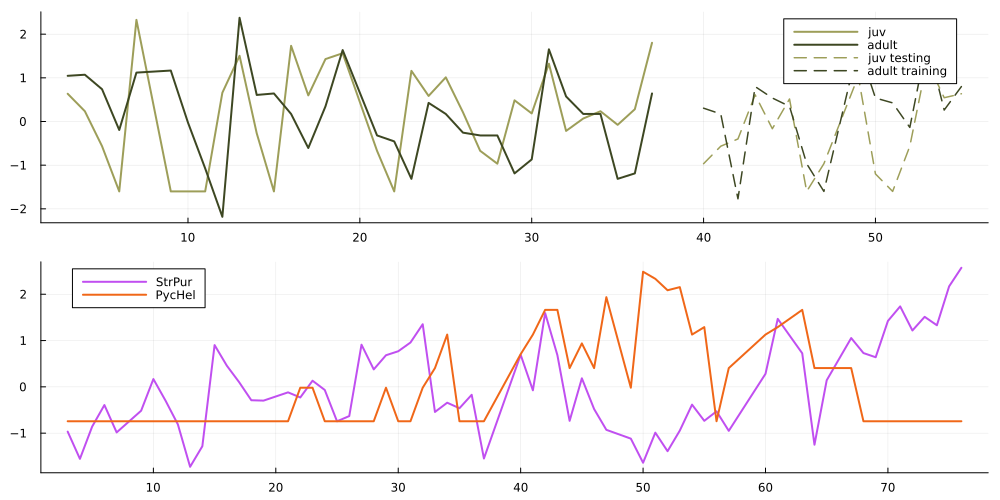

In [162]:
site = 4
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
dat = sort(dat,:PERIOD)

dat_states = dat[dat.SITE .== site,[:PERIOD,:MacJuv,:MacPyr]]
training = dat_states[dat_states.PERIOD .< 40,:]
testing = dat_states[(dat_states.PERIOD .>= 40) .& (dat_states.PERIOD .<= 55),:]
validation = dat_states[dat_states.PERIOD .> 55,:]

X = dat[dat.SITE .== site,[:PERIOD,:MesFra,:StrPur,:PteCal,:PycHel,:SemPul]]



p1 = Plots.plot(training.PERIOD, training.MacJuv, label = "juv", width = 2, color = "#9d9e59" )
Plots.plot!(training.PERIOD, training.MacPyr, label = "adult", width = 2, color = "#3d4722")
Plots.plot!(testing.PERIOD, testing.MacJuv, label = "juv testing", width = 1.5, linestyle = :dash, color = "#9d9e59")
Plots.plot!(testing.PERIOD, testing.MacPyr, label = "adult training", width = 1.5,linestyle = :dash, color = "#3d4722")
p2 = Plots.plot(X.PERIOD, X.StrPur, label = "StrPur", width = 2, color = "#c04ff0" )
Plots.plot!(X.PERIOD, X.PycHel, label = "PycHel", width = 2, color = "#f06718" )
plot(p1,p2, layout = (2,1), size = (1000,500))

In [ ]:
NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(3,2, hidden = 10)

function dudt(u,X,p,t)
    return NN(vcat(u,X[1:1]), p.NN) # index 3 is pycnopodia  ,X[1:2]
end

init_parameters = (NN = NNparameters, )

NODE = UniversalDiffEq.CustomDerivatives(training,X,dudt,init_parameters;time_column_name = "time")

UniversalDiffEq.train!(NODE, loss_function = "spline gradient matching", 
        regularization_weight = 1e-5, optim_options = (maxiter = 500, step_size = 0.025), 
        loss_options = (σ = 0.05, τ = 0.1, T = 4*size(training)[1]))
nothing

150
27610.836 23152.135 20736.353 20090.646 20210.451 20147.96 19617.394 18752.99 17787.509 16910.877 16224.534 15743.055 15412.474 15141.819 14846.714 14481.965 14047.456 13574.837 13106.954 12678.444 12303.741 11976.055 11675.87 11382.571 11083.173 10775.491 10466.618 10168.409 9891.118 9638.292 9405.57 9183.467 8963.159 8742.124 8524.902 8318.671 8128.329 7954.081 7792.104 7637.624 7487.663 7341.628 7200.454 7065.24 6936.174 6812.677 6694.444 6582.04 6476.185 6376.315 6280.362 6186.489 6094.802 6007.062 5924.651 5847.093 5772.791 5700.824 5631.612 5565.853 5503.236 5442.673 5383.646 5326.728 5272.648 5221.265 5171.802 5123.823 5077.514 5033.084 4990.298 4948.733 4908.302 4869.281 4831.818 4795.652 4760.46 4726.259 4693.228 4661.291 4630.189 4599.843 4570.328 4541.603 4513.533 4486.046 4459.1 4432.647 4406.709 4381.307 4356.323 4331.625 4307.251 4283.272 4259.626 4236.228 4213.073 4190.173 4167.507 4145.059 4122.808 4100.737 4078.856 4057.172 4035.67 4014.341 3993.184 3972.203 3951.3

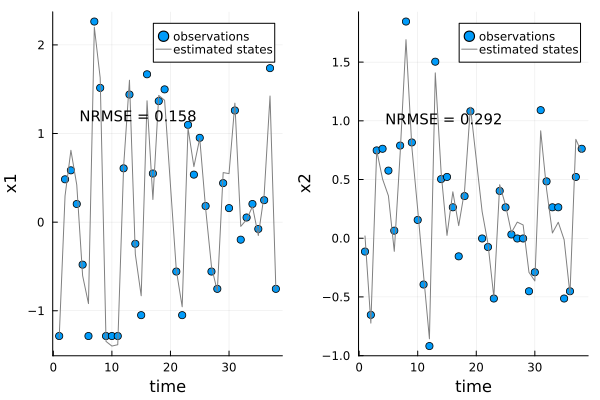

In [149]:
UniversalDiffEq.plot_state_estimates(NODE)

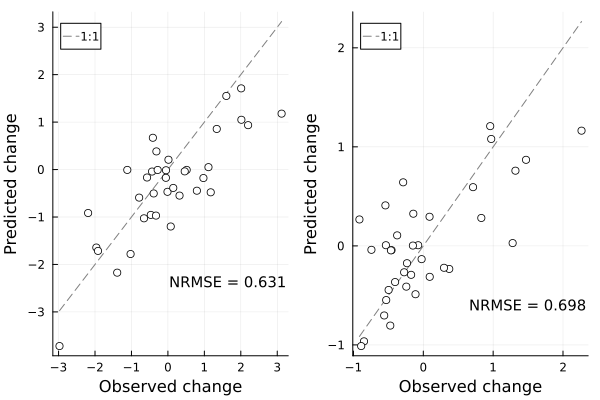

In [150]:
UniversalDiffEq.plot_predictions(NODE)

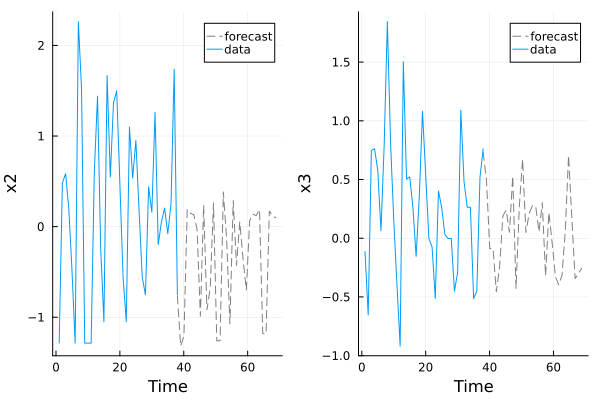

In [151]:
plt,(p1,p2)=UniversalDiffEq.plot_forecast(NODE, 30)
plt

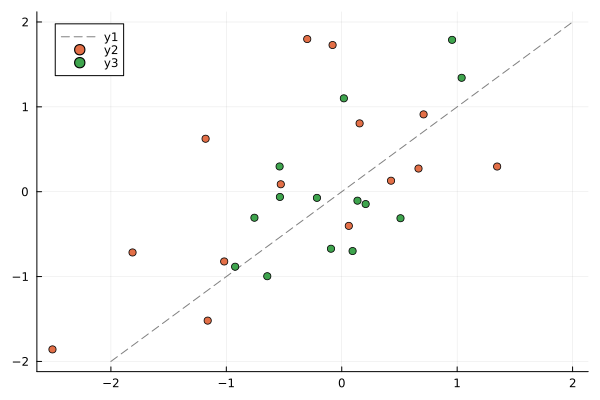

In [152]:
inits,obs,preds = UniversalDiffEq.predictions(NODE,testing)


delta_obs = obs .- inits
delta_pred = preds .- inits

Plots.plot([-2,2],[-2,2], color = "grey", linestyle = :dash)
Plots.scatter!(delta_pred[1,:], delta_obs[1,:])
Plots.scatter!(delta_pred[2,:], delta_obs[2,:])


In [153]:
cor(delta_obs[1,:], delta_pred[1,:])

0.598684221815609

In [154]:
cor(delta_obs[2,:], delta_pred[2,:])

0.6805975677128752